# Imports

In [1]:
pip install openpyxl

In [2]:
import pandas as pd

# Adding event type

In [ ]:
df = pd.read_excel("mood_tracker_i2.xlsx")

In [ ]:
df.columns = [c.strip().lower() for c in df.columns]
df['time'] = pd.to_datetime(df['time'])

#Compute session_day (05:00–next day 04:59)
df['session_day'] = (df['time'] - pd.Timedelta(hours=5)).dt.date

# Sort and get gaps (per annotator + session_day)
df = df.sort_values(['initials','session_day','time']).reset_index(drop=True)
df['prev_time'] = df.groupby(['initials','session_day'])['time'].shift(1)
df['gap']       = df['time'] - df['prev_time']

df['event'] = None

# Mark start_of_session for the first fill of each session_day
first_fill = df.groupby(['initials','session_day'])['time'] \
               .rank(method='first') == 1
df.loc[first_fill, 'event'] = 'start_of_session'

# Go through each group and apply break 
def classify(group):
    last_after_time = None
    prev_idx = None

    for idx, row in group.iterrows():
        if row.event == 'start_of_session':
            last_after_time = None
            prev_idx = idx
            continue

        # check for a potential break
        if pd.Timedelta(0) < row.gap <= pd.Timedelta(hours=1):
            # if it’s been >15m since the last after_break, start a new session
            if last_after_time and (row['time'] - last_after_time > pd.Timedelta(minutes=15)):
                df.at[idx, 'event'] = 'start_of_session'
                last_after_time = None
            else:
                # normal break: mark before/after
                df.at[prev_idx, 'event'] = 'before_break'
                df.at[idx,       'event'] = 'after_break'
                last_after_time = row['time']

        prev_idx = idx

# apply per annotator + session_day
for (_, _), grp in df.groupby(['initials','session_day']):
    classify(grp)


In [ ]:
df.to_excel('mood_tracker_i2_with_event.xlsx', index=False)

# Loading files

In [14]:
mood = pd.read_excel("mood_tracker_i2_with_event.xlsx")
sent = pd.read_excel("merged_Round2_all_sentiment.xlsx")

# Merging into 1 file

In [15]:
df = (
    mood
    .merge(
        sent,
        left_on=["initials", "platform", "row"],
        right_on=["annotator_name", "platform", "row"],
        how="left"
    )
    .sort_values(["initials", "platform", "row"])
    .reset_index(drop=True)
)

In [16]:
# Flag events
df["is_start"]  = df["event"] == "start_session"
df["is_before"] = df["event"] == "before_break"
df["is_after"]  = df["event"] == "after_break"

# Session IDs
df["session_id"] = df.groupby(["initials", "platform"])["is_start"].cumsum()

In [17]:
df

,id,time,initials,platform,row,mood,session_day,prev_time,gap,event,...,Author ID,Created At,Text,neg,neu,pos,is_start,is_before,is_after,session_id
0,13,2024-05-02 21:27:23,BS,Reddit,2,5,2024-05-02,NaT,NaN,start_session,...,NaN,NaN,NaN,0.220580,0.738522,0.040898,True,False,False,1
1,14,2024-05-02 22:06:35,BS,Reddit,27,5,2024-05-02,2024-05-02 21:27:23,0 days 00:39:12,before_break,...,NaN,NaN,NaN,0.440711,0.451780,0.107508,False,True,False,1
2,15,2024-05-02 22:09:18,BS,Reddit,27,6,2024-05-02,2024-05-02 22:06:35,0 days 00:02:43,after_break,...,NaN,NaN,NaN,0.440711,0.451780,0.107508,False,False,True,1
3,16,2024-05-03 11:45:07,BS,Reddit,27,5,2024-05-03,NaT,NaN,start_session,...,NaN,NaN,NaN,0.440711,0.451780,0.107508,True,False,False,2
4,17,2024-05-03 12:33:20,BS,Reddit,151,4,2024-05-03,2024-05-03 11:45:07,0 days 00:48:13,before_break,...,NaN,NaN,NaN,0.163818,0.695782,0.140400,False,True,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,8,2024-05-02 13:15:46,WL,Twitter,2000,5,2024-05-02,2024-05-02 12:12:30,0 days 01:03:16,before_break,...,'1725693269643067392,2024-03-05 22:15:49,@pepedownunder The sad thing is when Christian...,0.805328,0.183606,0.011066,False,True,False,2
438,9,2024-05-02 13:18:24,WL,Twitter,2000,6,2024-05-02,2024-05-02 13:15:46,0 days 00:02:38,after_break,...,'1725693269643067392,2024-03-05 22:15:49,@pepedownunder The sad thing is when Christian...,0.805328,0.183606,0.011066,False,False,True,2
439,10,2024-05-02 18:02:56,WL,Twitter,2000,5,2024-05-02,2024-05-02 13:18:24,0 days 04:44:32,start_session,...,'1725693269643067392,2024-03-05 22:15:49,@pepedownunder The sad thing is when Christian...,0.805328,0.183606,0.011066,True,False,False,3
440,11,2024-05-02 18:59:18,WL,Twitter,2700,5,2024-05-02,2024-05-02 18:02:56,0 days 00:56:22,before_break,...,'1183052995816230914,2024-04-27 08:20:28,Join the revolution in AI training with PIN3's...,0.002931,0.089437,0.907632,False,True,False,3


In [41]:
# Summarize breaks
summary_rows = []

for (initials, platform, sess), sess_df in df.groupby(["initials", "platform", "session_id"]):
    session_start = sess_df.index.min()
    before_idxs = sorted(sess_df.index[sess_df["is_before"]])
    after_idxs  = sorted(sess_df.index[sess_df["is_after"]])

    for i, before_idx in enumerate(before_idxs):
        # find the matching after index
        after_idx = next((a for a in after_idxs if a > before_idx), None)
        if after_idx is None:
            continue

        if i == 0:
            pre  = df.loc[session_start:before_idx, ["neg","neu","pos"]]
            post = pd.DataFrame(columns=["neg","neu","pos"])
        else:
            pre  = pd.DataFrame(columns=["neg","neu","pos"])
            prev_after = after_idxs[i-1]
            post = df.loc[prev_after:before_idx, ["neg","neu","pos"]]

        summary_rows.append({
            "initials":       initials,
            "platform":       platform,
            "session_id":     sess,
            "break_no":       i+1,
            "mood_before":    df.at[before_idx, "mood"],
            "mood_after":     df.at[after_idx,  "mood"],
            "mean_neg_pre":   pre["neg"].mean(),
            "mean_neu_pre":   pre["neu"].mean(),
            "mean_pos_pre":   pre["pos"].mean(),
            "mean_neg_post":  post["neg"].mean(),
            "mean_neu_post":  post["neu"].mean(),
            "mean_pos_post":  post["pos"].mean(),
            "rows_in_session": len(sess_df),
        })

break_summary = pd.DataFrame(summary_rows)


,initials,platform,session_day,break_no,row_before,row_after,rows_in_segment
0,BS,Reddit,2024-05-03,1,151,212,124
1,BS,Reddit,2024-05-30,1,800,1000,200
2,BS,Reddit,2024-06-01,1,1100,1110,100
3,BS,Reddit,2024-06-22,1,1300,1600,190
4,BS,Reddit,2024-08-27,1,2600,3000,-1
...,...,...,...,...,...,...,...
60,WL,Reddit,2024-05-12,1,4200,4400,200
61,WL,Reddit,2024-05-13,1,4600,4800,0
62,WL,Reddit,2024-05-18,1,6000,6200,0
63,WL,Twitter,2024-05-02,1,1500,2000,1000


In [35]:
break_summary

,initials,platform,session_id,break_no,mood_before,mood_after,mean_neg_pre,mean_neu_pre,mean_pos_pre,mean_neg_post,mean_neu_post,mean_pos_post,rows_in_session
0,BS,Reddit,1,1,5,6,0.330646,0.595151,0.074203,NaN,NaN,NaN,2
1,BS,Reddit,2,1,4,5,0.302264,0.573781,0.123954,NaN,NaN,NaN,2
2,BS,Reddit,3,1,5,5,0.259348,0.654195,0.086457,NaN,NaN,NaN,2
3,BS,Reddit,3,2,4,5,NaN,NaN,NaN,0.208412,0.652921,0.138667,2
4,BS,Reddit,4,1,5,6,0.260556,0.570173,0.169272,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,WL,Reddit,15,1,4,5,0.648303,0.334916,0.016781,NaN,NaN,NaN,2
148,WL,Twitter,1,1,5,5,0.833159,0.157038,0.009803,NaN,NaN,NaN,2
149,WL,Twitter,2,1,7,7,0.574758,0.352299,0.072942,NaN,NaN,NaN,2
150,WL,Twitter,2,2,5,6,NaN,NaN,NaN,0.753208,0.231368,0.015424,2


In [20]:
df.to_excel("merged_with_sessions.xlsx", index=False)
break_summary.to_excel("break_summary.xlsx", index=False)

# Statistical analyses

## Imports

In [2]:
!pip install statsmodels==0.14.4

In [3]:
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [4]:
# Load data
bs = pd.read_excel("break_summary.xlsx")
df = pd.read_excel("merged_with_sessions.xlsx")

In [12]:
# Helper: descriptive stats
def describe(name, series):
    s = series.dropna()
    return (f"{name}: n={len(s)}, mean={s.mean():.3f}, std={s.std(ddof=1):.3f}, "
            f"median={s.median():.3f}, IQR={s.quantile(0.75)-s.quantile(0.25):.3f}")

# Helper: compute Wilcoxon effect size r
def wilcoxon_effect_size(d):
    N = len(d)
    W, p = stats.wilcoxon(d, zero_method='wilcox', alternative='two-sided')
    mu = N*(N+1)/4
    sigma = np.sqrt(N*(N+1)*(2*N+1)/24)
    Z = (W - mu)/sigma
    return W, p, Z/np.sqrt(N), Z

## Descriptive stats

In [ ]:
bs

,session_id,break_no,mood_before,mood_after,mean_neg_pre,mean_neu_pre,mean_pos_pre,mean_neg_post,mean_neu_post,mean_pos_post,rows_in_session
count,152.000000,152.000000,152.000000,152.000000,113.000000,113.000000,113.000000,38.000000,38.000000,38.000000,152.000000
mean,11.960526,1.342105,4.243421,4.763158,0.447304,0.425525,0.127171,0.390553,0.446316,0.163131,4.401316
std,9.469282,0.652101,0.983282,0.896918,0.225505,0.189679,0.168960,0.249429,0.211125,0.225300,1.838729
min,1.000000,1.000000,2.000000,2.000000,0.007437,0.090090,0.009571,0.001977,0.050867,0.007227,3.000000
25%,5.000000,1.000000,4.000000,4.000000,0.302264,0.270416,0.024660,0.213401,0.291394,0.031957,3.000000
50%,9.000000,1.000000,4.000000,5.000000,0.452885,0.445299,0.046082,0.390950,0.458424,0.061536,3.000000
75%,18.000000,2.000000,5.000000,5.000000,0.619657,0.556311,0.155534,0.515254,0.642293,0.148535,5.000000
max,36.000000,4.000000,7.000000,7.000000,0.882238,0.939425,0.892396,0.941906,0.806063,0.939904,9.000000


In [14]:
# Build a unique session key
bs["session_key"] = (
    bs["initials"].astype(str) + "|" +
    bs["platform"].astype(str) + "|" +
    bs["session_id"].astype(str)
)

# Total counts
total_sessions      = bs["session_key"].nunique()
total_breaks        = len(bs)

#  Count breaks per session
break_counts = bs.groupby("session_key").size()

# Sessions with exactly 1 break vs. 2+ breaks
sessions_one_break   = (break_counts == 1).sum()
sessions_multi_break = (break_counts >= 2).sum()

# Print summary
print(f"Total sessions:               {total_sessions}")
print(f"Total breaks:                 {total_breaks}")
print(f"Sessions with exactly 1 break:{sessions_one_break}")
print(f"Sessions with 2 or more breaks: {sessions_multi_break}")


Total sessions:               113
Total breaks:                 152
Sessions with exactly 1 break:85
Sessions with 2 or more breaks: 28


In [21]:
# Extract mood series
session_start = df.loc[df["event"] == "start_session", "mood"]
pre_break     = bs["mood_before"]
post_break    = bs["mood_after"]

# Descriptive helper
def describe(series):
    s = series.dropna()
    return {
        "n":      s.count(),
        "mean":   round(s.mean(), 3),
        "sd":     round(s.std(ddof=1), 3),
        "median": round(s.median(), 3),
        "25%":    round(s.quantile(0.25), 3),
        "75%":    round(s.quantile(0.75), 3),
        "range":  f"{round(s.min(), 3)}–{round(s.max(), 3)}"
    }

# Build Table 1: Mood descriptives
table1 = pd.DataFrame([
    {"Timepoint": "Session start", **describe(session_start)},
    {"Timepoint": "Pre-break",      **describe(pre_break)},
    {"Timepoint": "Post-break",     **describe(post_break)}
])

# Build Table 2: Sentiment descriptives (pre-break)
sentiment_measures = [
    ("Negative sentiment", "mean_neg_pre"),
    ("Neutral sentiment",  "mean_neu_pre"),
    ("Positive sentiment", "mean_pos_pre")
]
table2 = pd.DataFrame([
    {"Measure": name, **describe(bs[col])}
    for name, col in sentiment_measures
])

# Print tables
print("\nTable 1: Mood Descriptive Statistics")
print(table1.to_string(index=False))

print("\nTable 2: Pre-Break Sentiment Descriptive Statistics")
print(table2.to_string(index=False))


Table 1: Mood Descriptive Statistics
    Timepoint   n  mean    sd  median  25%  75% range
Session start 126 4.405 1.021     4.0  4.0  5.0   2–7
    Pre-break 152 4.243 0.983     4.0  4.0  5.0   2–7
   Post-break 152 4.763 0.897     5.0  4.0  5.0   2–7

Table 2: Pre-Break Sentiment Descriptive Statistics
           Measure   n  mean    sd  median   25%   75%       range
Negative sentiment 113 0.447 0.226   0.453 0.302 0.620 0.007–0.882
 Neutral sentiment 113 0.426 0.190   0.445 0.270 0.556  0.09–0.939
Positive sentiment 113 0.127 0.169   0.046 0.025 0.156  0.01–0.892


In [53]:
# Build a session_key in both dataframes
df["session_key"] = (
    df["initials"].astype(str) + "|" +
    df["platform"] .astype(str) + "|" +
    df["session_id"].astype(str)
)
bs["session_key"] = (
    bs["initials"].astype(str) + "|" +
    bs["platform"] .astype(str) + "|" +
    bs["session_id"].astype(str)
)

# Compute session & break counts
#   – all sessions (by a unique start_session)
session_starts = (
    df[df["event"] == "start_session"]
    .drop_duplicates(subset="session_key")
)
total_sessions_all       = session_starts["session_key"].nunique()
#   – sessions with at least one break
total_sessions_with_breaks = bs["session_key"].nunique()
#   – total breaks
total_breaks             = len(bs)

#   – breaks per session
break_counts = bs.groupby("session_key").size()
sessions_one_break   = (break_counts == 1).sum()
sessions_multi_break = (break_counts >= 2).sum()

# Print summary
print(f"Total sessions (annotated):             {total_sessions_all}")
print(f"Sessions with ≥1 break:                 {total_sessions_with_breaks}")
print(f"Total breaks:                           {total_breaks}")
print(f"Sessions with exactly 1 break:          {sessions_one_break}")
print(f"Sessions with 2 or more breaks:         {sessions_multi_break}")

# Descriptive tables

# Extract mood at session start (one per session), pre-break, and post-break
session_start = session_starts["mood"]
pre_break     = bs["mood_before"]
post_break    = bs["mood_after"]

# Descriptive helper
def describe(series):
    s = series.dropna()
    return {
        "n":      s.count(),
        "mean":   round(s.mean(), 3),
        "sd":     round(s.std(ddof=1), 3),
        "median": round(s.median(), 3),
        "25%":    round(s.quantile(0.25), 3),
        "75%":    round(s.quantile(0.75), 3),
        "range":  f"{round(s.min(), 3)}–{round(s.max(), 3)}"
    }

# Build Table 1: Mood descriptives
table1 = pd.DataFrame([
    {"Timepoint": "Session start", **describe(session_start)},
    {"Timepoint": "Pre-break",      **describe(pre_break)},
    {"Timepoint": "Post-break",     **describe(post_break)}
])

# Build Table 2: Sentiment descriptives (pre-break)
sentiment_measures = [
    ("Negative sentiment (pre)", "mean_neg_pre"),
    ("Neutral sentiment (pre)",  "mean_neu_pre"),
    ("Positive sentiment (pre)", "mean_pos_pre")
]
table2 = pd.DataFrame([
    {"Measure": name, **describe(bs[col])}
    for name, col in sentiment_measures
])

# Print tables
print("\nTable 1: Mood Descriptive Statistics")
print(table1.to_string(index=False))

print("\nTable 2: Pre-Break Sentiment Descriptive Statistics")
print(table2.to_string(index=False))


Total sessions (annotated):             126
Sessions with ≥1 break:                 113
Total breaks:                           152
Sessions with exactly 1 break:          85
Sessions with 2 or more breaks:         28

Table 1: Mood Descriptive Statistics
    Timepoint   n  mean    sd  median  25%  75% range
Session start 126 4.405 1.021     4.0  4.0  5.0   2–7
    Pre-break 152 4.243 0.983     4.0  4.0  5.0   2–7
   Post-break 152 4.763 0.897     5.0  4.0  5.0   2–7

Table 2: Pre-Break Sentiment Descriptive Statistics
                 Measure   n  mean    sd  median   25%   75%       range
Negative sentiment (pre) 113 0.447 0.226   0.453 0.302 0.620 0.007–0.882
 Neutral sentiment (pre) 113 0.426 0.190   0.445 0.270 0.556  0.09–0.939
Positive sentiment (pre) 113 0.127 0.169   0.046 0.025 0.156  0.01–0.892


## H1: Mean mood immediately before_break equals mean mood immediately after_break.

In [83]:
# H1: Mood change across breaks
print("=== H1: Mood change across breaks ===")
print("H0: Median(mood_after − mood_before) = 0")
print("H1: Median(mood_after − mood_before) ≠ 0\n")

# Compute mood change
d1 = bs["mood_after"] - bs["mood_before"]
d1 = d1.dropna()
N = len(d1)

# Descriptive statistics
mean_d1 = d1.mean()
std_d1 = d1.std(ddof=1)
median_d1 = d1.median()
iqr_d1 = d1.quantile(0.75) - d1.quantile(0.25)

print(f"N = {N}")
print(f"Mean = {mean_d1:.3f}")
print(f"Standard deviation = {std_d1:.3f}")
print(f"Median = {median_d1:.1f}")
print(f"IQR = {iqr_d1:.1f}")

# Wilcoxon test
W, p = stats.wilcoxon(d1, zero_method='wilcox', alternative='two-sided')

# Effect size r
mu_W = N * (N + 1) / 4
sigma_W = np.sqrt(N * (N + 1) * (2 * N + 1) / 24)
Z = (W - mu_W) / sigma_W
r = Z / np.sqrt(N)

# Output results
print(f"\nWilcoxon signed-rank test:")
print(f"W = {W:.3f}")
print(f"Z ≈ {Z:.3f}")
print(f"p = {p:.3f}")
print(f"Effect size r = {r:.3f}")
print("Decision:", "Reject H0" if p < 0.05 else "Fail to reject H0")

=== H1: Mood change across breaks ===
H0: Median(mood_after − mood_before) = 0
H1: Median(mood_after − mood_before) ≠ 0

N = 152
Mean = 0.520
Standard deviation = 0.598
Median = 1.0
IQR = 1.0

Wilcoxon signed-rank test:
W = 114.000
Z ≈ -10.485
p = 0.000
Effect size r = -0.850
Decision: Reject H0


## H2: The mean mood at session start equals the mean mood just before the first break.

In [86]:
# Prepare data for H2
bs1 = bs[bs["break_no"] == 1].copy()

# Extract mood at session start
start_moods = (
    df[df["is_start"]]
    .groupby(["initials", "platform", "session_id"])["mood"]
    .first()
    .reset_index()
    .rename(columns={"mood": "mood_start"})
)
bs1 = bs1.merge(start_moods, on=["initials", "platform", "session_id"])

# Compute difference
d2 = bs1["mood_before"] - bs1["mood_start"]
d2 = d2.dropna()
N = len(d2)

# Descriptive stats
mean_d2 = d2.mean()
std_d2 = d2.std(ddof=1)
median_d2 = d2.median()
iqr_d2 = d2.quantile(0.75) - d2.quantile(0.25)

# Shapiro-Wilk normality test
sw_stat, sw_p = stats.shapiro(d2)

# Wilcoxon test
W, p = stats.wilcoxon(d2, zero_method='wilcox', alternative='two-sided')

# Effect size r
mu_W = N * (N + 1) / 4
sigma_W = np.sqrt(N * (N + 1) * (2 * N + 1) / 24)
Z = (W - mu_W) / sigma_W
r = Z / np.sqrt(N)

# Output
print("=== H2: Mood change from session start to first break ===")
print("H0: Median(mood_before − mood_start) = 0")
print("H1: Median(mood_before − mood_start) ≠ 0\n")

print(f"N = {N}")
print(f"Mean = {mean_d2:.3f}")
print(f"Standard deviation = {std_d2:.3f}")
print(f"Median = {median_d2:.1f}")
print(f"IQR = {iqr_d2:.1f}")
print(f"\nShapiro–Wilk test: W = {sw_stat:.3f}, p = {sw_p:.3f}")

print(f"\nWilcoxon signed-rank test:")
print(f"W = {W:.3f}")
print(f"Z ≈ {Z:.3f}")
print(f"p = {p:.3f}")
print(f"Effect size r = {r:.3f}")
print("Decision:", "Reject H0" if p < 0.05 else "Fail to reject H0")

=== H2: Mood change from session start to first break ===
H0: Median(mood_before − mood_start) = 0
H1: Median(mood_before − mood_start) ≠ 0

N = 113
Mean = -0.310
Standard deviation = 0.669
Median = 0.0
IQR = 1.0

Shapiro–Wilk test: W = 0.807, p = 0.000

Wilcoxon signed-rank test:
W = 207.000
Z ≈ -8.633
p = 0.000
Effect size r = -0.812
Decision: Reject H0


# Visualisations

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

## H1

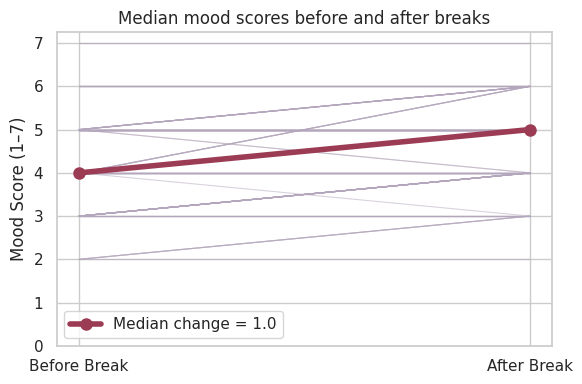

In [20]:
# Prepare paired mood data
before = bs["mood_before"].values
after  = bs["mood_after"].values

# Compute median values
median_before = pd.Series(before).median()
median_after  = pd.Series(after).median()
median_diff   = median_after - median_before

# Grab your deep violet from the twilight_shifted palette
pal          = sns.color_palette("twilight_shifted", 256)
dark_purple  = pal[0]      # deep violet

# Set seaborn style
sns.set(style="whitegrid")

# Create slope chart
fig, ax = plt.subplots(figsize=(6, 4))

# Plot individual lines in your deep purple
for b, a in zip(before, after):
    ax.plot([0, 1], [b, a],
            color='#b4a6bc',
            alpha=0.5,
            linewidth=0.8)

# Overlay median slope line in your rose-berry
ax.plot([0, 1],
        [median_before, median_after],
        color='#9c3c54',
        linewidth=4,
        marker='o',
        markersize=8,
        label=f"Median change = {median_diff:.1f}")

# Customize plot
ax.set_xticks([0, 1])
ax.set_xticklabels(["Before Break", "After Break"])
ax.set_ylabel("Mood Score (1–7)")
ax.set_title("Median mood scores before and after breaks")
ax.legend()

# Force the y-axis to start at zero
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

## H2

/tmp/ipykernel_40/2985452478.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


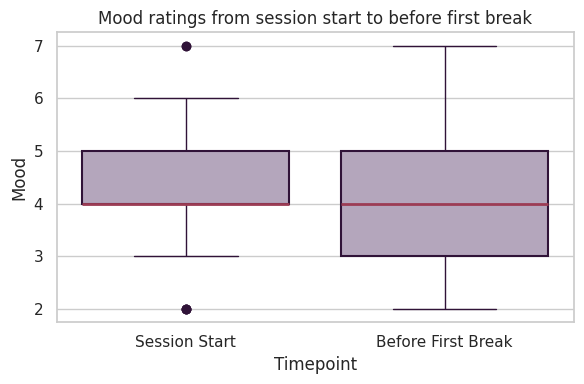

In [17]:
# Prepare data for first break
bs1 = bs[bs["break_no"] == 1].copy()
start_moods = (
    df[df["event"] == "start_session"]
      .groupby(["initials","platform","session_id"])["mood"]
      .first()
      .rename("mood_start")
)
bs1 = bs1.join(start_moods, on=["initials","platform","session_id"])

# Melt for plotting
plot_df = pd.melt(
    bs1,
    value_vars=["mood_start", "mood_before"],
    var_name="Timepoint",
    value_name="Mood"
)
plot_df["Timepoint"] = plot_df["Timepoint"].map({
    "mood_start": "Session Start",
    "mood_before": "Before First Break"
})

# Compute medians
median_start = plot_df[plot_df["Timepoint"] == "Session Start"]["Mood"].median()
median_before = plot_df[plot_df["Timepoint"] == "Before First Break"]["Mood"].median()
median_diff = median_before - median_start

# Set seaborn style
sns.set(style="whitegrid")


# pick the first and last color from the palette
pal = sns.color_palette("twilight_shifted", 256)
dark_purple = pal[  0]   # deep violet

plt.figure(figsize=(6,4))
sns.boxplot(
    x="Timepoint", y="Mood", data=plot_df,
    boxprops=dict(facecolor="#b4a6bc", edgecolor=dark_purple, linewidth=1.5),
    whiskerprops=dict(color=dark_purple),
    capprops=dict(color=dark_purple),
    medianprops=dict(color='#9c3c54', linewidth=2),
    flierprops=dict(markerfacecolor=dark_purple, markeredgecolor=dark_purple),
    palette=[dark_purple, dark_purple]  # or [dark_purple, warm_amber]
)


plt.title("Mood ratings from session start to before first break")  # <- Add your custom title here
plt.tight_layout()
plt.show()


## Platforms sentiment

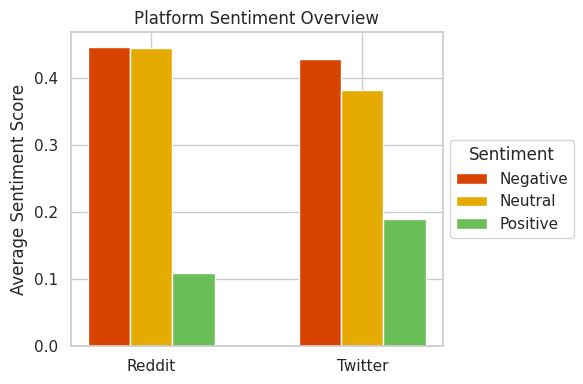

In [156]:
# 1. Drop TikTok
df = df[df["platform"].str.lower() != "tiktok"]

# 2. Compute average sentiment per platform
mean_by_platform = (
    df
    .groupby("platform")[["neg","neu","pos"]]
    .mean()
    .reset_index()
)

platforms = mean_by_platform["platform"]
metrics   = ["neg","neu","pos"]
x         = np.arange(len(platforms))
width     = 0.2

# 3. Custom colours
neg_color = "#D94302"  # muted red
neu_color = "#E6AB02"  # mustard yellow
pos_color = "#6BBF59"  # soft green
colors    = [neg_color, neu_color, pos_color]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(6,4))

# 4. Plot each sentiment bar
for i, m in enumerate(metrics):
    ax.bar(
        x + i*width,
        mean_by_platform[m],
        width,
        color=colors[i],
        label=m.capitalize()
    )

# 5. Labels & title
ax.set_xticks(x + width)
ax.set_xticklabels(platforms)
ax.set_ylabel("Average Sentiment Score")
ax.set_title("Platform Sentiment Overview")

# # 6a. Legend on the right, outside the plot
handles, _ = ax.get_legend_handles_labels()
new_labels = ["Negative", "Neutral", "Positive"]
ax.legend(handles, new_labels,
          title="Sentiment",
          loc="center left",
          bbox_to_anchor=(1, 0.5))


plt.tight_layout()
plt.show()

## Breaks distribution

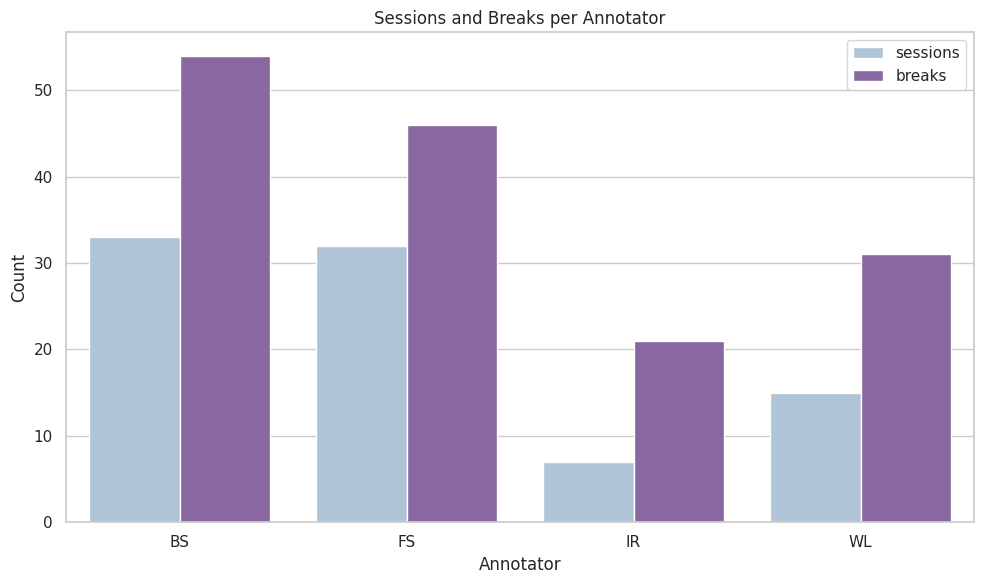

In [50]:
# Compute counts
session_counts = bs.groupby("initials")["session_id"].nunique().reset_index(name="sessions")
break_counts   = bs.groupby("initials").size().reset_index(name="breaks")
df_counts = session_counts.merge(break_counts, on="initials")

# Melt for plotting
df_melt = df_counts.melt(id_vars="initials", var_name="Metric", value_name="Count")

# Plot 
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

palette = sns.color_palette("BuPu", 2)

sns.barplot(
    data=df_melt,
    x="initials",
    y="Count",
    hue="Metric",
    hue_order=["sessions", "breaks"],
    palette=palette
)


plt.xlabel("Annotator")
plt.ylabel("Count")
plt.title("Sessions and Breaks per Annotator")
plt.legend(title="")
plt.tight_layout()
plt.show()

# Insignificant analyses

## H3: Correlation between negative sentiment and mood drop

In [95]:
# Prepare for Correlation A: first break only
bs1 = bs[bs["break_no"] == 1].copy()
start_moods = (
    df[df["is_start"]]
      .groupby(["initials","platform","session_id"])["mood"]
      .first()
      .rename("mood_start")
)
bs1 = bs1.join(start_moods, on=["initials","platform","session_id"])
bs1["delta_start"] = bs1["mood_before"] - bs1["mood_start"]

# Correlation A
negA = bs1["mean_neg_pre"].dropna()
deltaA = bs1["delta_start"].dropna()
commonA = negA.index.intersection(deltaA.index)
negA = negA.loc[commonA]
deltaA = deltaA.loc[commonA]

print("=== Correlation A ===")
print("H0: ρ = 0 (no correlation between pre-break neg and mood change from session start to before break)")
print("H1: ρ ≠ 0\n")

print(f"Descriptive stats for mean_neg_pre: n={len(negA)}, mean={negA.mean():.3f}, std={negA.std(ddof=1):.3f}")
print(f"Descriptive stats for delta_start: n={len(deltaA)}, mean={deltaA.mean():.3f}, std={deltaA.std(ddof=1):.3f}\n")

sw_negA, p_negA = stats.shapiro(negA)
sw_dA,   p_dA   = stats.shapiro(deltaA)
print(f"Shapiro-Wilk mean_neg_pre: W={sw_negA:.3f}, p={p_negA:.3f}")
print(f"Shapiro-Wilk delta_start:   W={sw_dA:.3f}, p={p_dA:.3f}\n")

testA = stats.pearsonr if (p_negA > alpha and p_dA > alpha) else stats.spearmanr
statA, pA = testA(negA, deltaA)
print(f"{'Pearson' if testA == stats.pearsonr else 'Spearman'} r = {statA:.3f}, p = {pA:.3f}")
print("Decision:", "Reject H0" if pA < alpha else "Fail to reject H0")
print("\n" + "="*50 + "\n")

# Correlation B: all breaks
bs["delta_break"] = bs["mood_after"] - bs["mood_before"]
maskB = bs["mean_neg_pre"].notna() & bs["delta_break"].notna()
negB = bs.loc[maskB, "mean_neg_pre"]
deltaB = bs.loc[maskB, "delta_break"]

print("=== Correlation B ===")
print("H0: ρ = 0 (no correlation between pre-break neg and mood change at break)")
print("H1: ρ ≠ 0\n")

print(f"Descriptive stats for mean_neg_pre: n={len(negB)}, mean={negB.mean():.3f}, std={negB.std(ddof=1):.3f}")
print(f"Descriptive stats for delta_break: n={len(deltaB)}, mean={deltaB.mean():.3f}, std={deltaB.std(ddof=1):.3f}\n")

sw_negB, p_negB = stats.shapiro(negB)
sw_dB,   p_dB   = stats.shapiro(deltaB)
print(f"Shapiro-Wilk mean_neg_pre: W={sw_negB:.3f}, p={p_negB:.3f}")
print(f"Shapiro-Wilk delta_break:   W={sw_dB:.3f}, p={p_dB:.3f}\n")

testB = stats.pearsonr if (p_negB > alpha and p_dB > alpha) else stats.spearmanr
statB, pB = testB(negB, deltaB)
print(f"{'Pearson' if testB == stats.pearsonr else 'Spearman'} r = {statB:.3f}, p = {pB:.3f}")
print("Decision:", "Reject H0" if pB < alpha else "Fail to reject H0")


=== Correlation A ===
H0: ρ = 0 (no correlation between pre-break neg and mood change from session start to before break)
H1: ρ ≠ 0

Descriptive stats for mean_neg_pre: n=113, mean=0.447, std=0.226
Descriptive stats for delta_start: n=113, mean=-0.310, std=0.669

Shapiro-Wilk mean_neg_pre: W=0.976, p=0.038
Shapiro-Wilk delta_start:   W=0.807, p=0.000

Spearman r = -0.160, p = 0.090
Decision: Fail to reject H0


=== Correlation B ===
H0: ρ = 0 (no correlation between pre-break neg and mood change at break)
H1: ρ ≠ 0

Descriptive stats for mean_neg_pre: n=113, mean=0.447, std=0.226
Descriptive stats for delta_break: n=113, mean=0.522, std=0.628

Shapiro-Wilk mean_neg_pre: W=0.976, p=0.038
Shapiro-Wilk delta_break:   W=0.786, p=0.000

Spearman r = -0.047, p = 0.620
Decision: Fail to reject H0


## H4: Session length predicts mood drop

In [98]:
# Prepare break_summary for first breaks
bs1 = bs[bs["break_no"] == 1].copy()

# Merge session start mood to compute delta_start
start_moods = (
    df[df["is_start"]]
      .groupby(["initials","platform","session_id"])["mood"]
      .first()
      .reset_index()
      .rename(columns={"mood": "mood_start"})
)
bs1 = bs1.merge(start_moods, on=["initials","platform","session_id"])
bs1["delta_start"] = bs1["mood_before"] - bs1["mood_start"]

# Descriptive statistics
n = len(bs1)
rows_mean = bs1["rows_in_session"].mean()
rows_std  = bs1["rows_in_session"].std(ddof=1)
delta_mean = bs1["delta_start"].mean()
delta_std  = bs1["delta_start"].std(ddof=1)

print("=== H5: Session length predicts mood drop ===")
print("H0: The slope of delta_start ~ rows_in_session is zero")
print("H1: The slope is nonzero\n")

print(f"Descriptive stats for rows_in_session: n={n}, mean={rows_mean:.3f}, std={rows_std:.3f}")
print(f"Descriptive stats for delta_start:   n={n}, mean={delta_mean:.3f}, std={delta_std:.3f}\n")

# Linear regression
X = sm.add_constant(bs1["rows_in_session"])
y = bs1["delta_start"]
model = sm.OLS(y, X, missing="drop").fit()

# Extract results
slope    = model.params["rows_in_session"]
p_value  = model.pvalues["rows_in_session"]
r_squared = model.rsquared

print("OLS regression results:")
print(f"Slope = {slope:.3f}")
print(f"p-value = {p_value:.3f}")
print(f"R-squared = {r_squared:.3f}")
print("Decision:", "Reject H0" if p_value < 0.05 else "Fail to reject H0")

=== H5: Session length predicts mood drop ===
H0: The slope of delta_start ~ rows_in_session is zero
H1: The slope is nonzero

Descriptive stats for rows_in_session: n=113, mean=3.717, std=1.385
Descriptive stats for delta_start:   n=113, mean=-0.310, std=0.669

OLS regression results:
Slope = 0.066
p-value = 0.152
R-squared = 0.018
Decision: Fail to reject H0


## H5: Mood change in the first session segment (session start → first break) differs by time of day

In [15]:
# Prepare data for mood_before - mood_start for first break
bs1 = bs[bs["break_no"] == 1].copy()

# Merge in start session mood
start_moods = (
    df[df["is_start"]]
      .groupby(["initials","platform","session_id"])["mood"]
      .first()
      .rename("mood_start")
)
bs1 = bs1.join(start_moods, on=["initials","platform","session_id"])
bs1["delta_start"] = bs1["mood_before"] - bs1["mood_start"]

# Merge in session start time
start_times = (
    df[df["is_start"]]
      .groupby(["initials","platform","session_id"])["time"]
      .first()
      .rename("start_time")
)
bs1 = bs1.join(start_times, on=["initials","platform","session_id"])

# Time-of-Day categories
def tod_category(hour):
    if 0 <= hour < 5:
        return "night (0-5)"
    elif hour < 12:
        return "morning (5-12)"
    elif hour < 17:
        return "afternoon (12-17)"
    else:
        return "evening (17-24)"

bs1["hour"] = bs1["start_time"].dt.hour
bs1["tod"] = bs1["hour"].apply(tod_category)

# Descriptive stats by category
desc = bs1.groupby("tod")["delta_start"].agg(
    n="count",
    mean="mean",
    std="std",
    median="median",
    IQR=lambda x: x.quantile(0.75) - x.quantile(0.25)
).reset_index()

print("Descriptive statistics of Δ_start by Time-of-Day:")
print(desc.to_string(index=False))

# Kruskal-Wallis test across all four categories
groups = [group["delta_start"].values for name, group in bs1.groupby("tod")]
H, p_kw = stats.kruskal(*groups)

print("\nKruskal-Wallis test across Time-of-Day categories:")
print(f"H = {H:.3f}, p = {p_kw:.3f}")

# Effect size 
N = len(bs1)
k = len(groups)
epsilon2 = (H - k + 1) / (N - k)
print(f"Effect size (epsilon^2) = {epsilon2:.3f}")

alpha = 0.05
print("\nDecision:", "Reject H0: Δ_start differs by Time-of-Day" if p_kw < alpha else "Fail to reject H0: no difference by Time-of-Day")


Descriptive statistics of Δ_start by Time-of-Day:
              tod  n      mean      std  median  IQR
afternoon (12-17) 35 -0.342857 0.683540     0.0  1.0
  evening (17-24) 51 -0.313725 0.647771     0.0  1.0
   morning (5-12) 23 -0.217391 0.735868     0.0  1.0
      night (0-5)  4 -0.500000 0.577350    -0.5  1.0

Kruskal-Wallis test across Time-of-Day categories:
H = 0.950, p = 0.813
Effect size (epsilon^2) = -0.019

Decision: Fail to reject H0: no difference by Time-of-Day


## H6: Platforms

In [21]:
alpha = 0.05


bs1 = bs[bs["break_no"] == 1].copy()
# Merge in session start mood
start_moods = (
    df[df["is_start"]]
      .groupby(["initials","platform","session_id"])["mood"]
      .first()
      .rename("mood_start")
)
bs1 = bs1.join(start_moods, on=["initials","platform","session_id"])
bs1["delta_start"] = bs1["mood_before"] - bs1["mood_start"]

# Descriptive statistics by platform
desc_platform = bs1.groupby("platform")["delta_start"].agg(
    n="count",
    mean="mean",
    std="std",
    median="median",
    IQR=lambda x: x.quantile(0.75) - x.quantile(0.25)
).reset_index()

print("Descriptive statistics of Δ_start by platform:")
print(desc_platform.to_string(index=False))

# Kruskal-Wallis test for Δ_start across platforms
groups = [group["delta_start"].values for _, group in bs1.groupby("platform")]
H, p_kw = stats.kruskal(*groups)
N = len(bs1)
k = desc_platform.shape[0]
epsilon2 = (H - k + 1) / (N - k)

print(f"\nKruskal-Wallis H = {H:.3f}, p = {p_kw:.3f}")
print(f"Effect size (epsilon^2) ≈ {epsilon2:.3f}")
print("Decision:", "Reject H0: Δ_start differs by platform" if p_kw < alpha else "Fail to reject H0: no difference by platform")

# Spearman correlation of mean_neg_pre vs Δ_start by platform
print("\nSpearman correlations (mean_neg_pre vs Δ_start) by platform:")
for plat, group in bs1.groupby("platform"):
    neg = group["mean_neg_pre"].dropna()
    delta = group["delta_start"].dropna()
    idx = neg.index.intersection(delta.index)
    neg = neg.loc[idx]
    delta = delta.loc[idx]
    if len(neg) < 3:
        print(f"- {plat}: insufficient data (n = {len(neg)})")
        continue
    rho, p_val = stats.spearmanr(neg, delta)
    sig = "(p<0.05)" if p_val < alpha else ""
    print(f"- {plat}: n = {len(neg)}, ρ = {rho:.3f}, p = {p_val:.3f} {sig}")


Descriptive statistics of Δ_start by platform:
platform  n      mean      std  median  IQR
  Reddit 82 -0.268293 0.648812     0.0  1.0
 Twitter 31 -0.419355 0.719916     0.0  1.0

Kruskal-Wallis H = 0.982, p = 0.322
Effect size (epsilon^2) ≈ -0.000
Decision: Fail to reject H0: no difference by platform

Spearman correlations (mean_neg_pre vs Δ_start) by platform:
- Reddit: n = 82, ρ = -0.177, p = 0.112 
- Twitter: n = 31, ρ = -0.141, p = 0.450 


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8089b35f-0ab4-4c02-a70f-401a3c5ce0c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>